In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [14]:
file_path = '/Users/usuario1/Desktop/P_ia/sp500.csv'
data = pd.read_csv(file_path)

In [15]:
file_path = '/Users/usuario1/Desktop/P_ia/sp500.csv'
data = pd.read_csv(file_path)

In [16]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

In [17]:
data['Open-Close'] = data['Open'] - data['Close']
data['High-Low'] = data['High'] - data['Low']
data['3day MA'] = data['Close'].shift(1).rolling(window=3).mean()
data['10day MA'] = data['Close'].shift(1).rolling(window=10).mean()
data['30day MA'] = data['Close'].shift(1).rolling(window=30).mean()
data['Std_dev'] = data['Close'].rolling(5).std()
data['5day MA'] = data['Close'].shift(1).rolling(window=5).mean()

In [18]:
data = data.dropna()

In [19]:
X = data[['Open-Close', 'High-Low', '3day MA', '10day MA', '30day MA', 'Std_dev', '5day MA']]
y = data['Close']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
best_mse = float("inf")
best_params = {}

In [22]:

for n_estimators in [100, 200]:
    for max_depth in [10, 20]:
        for min_samples_split in [2, 5]:
            rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            if mse < best_mse:
                best_mse = mse
                best_params = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split
                }


In [23]:
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)
y_pred_best = rf_best.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred_best)

final_mse, best_params

(7.990707413712055,
 {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5})

In [24]:
y_test_normalized = (y_test - y_test.min()) / (y_test.max() - y_test.min())
y_pred_best_normalized = (y_pred_best - y_pred_best.min()) / (y_pred_best.max() - y_pred_best.min())

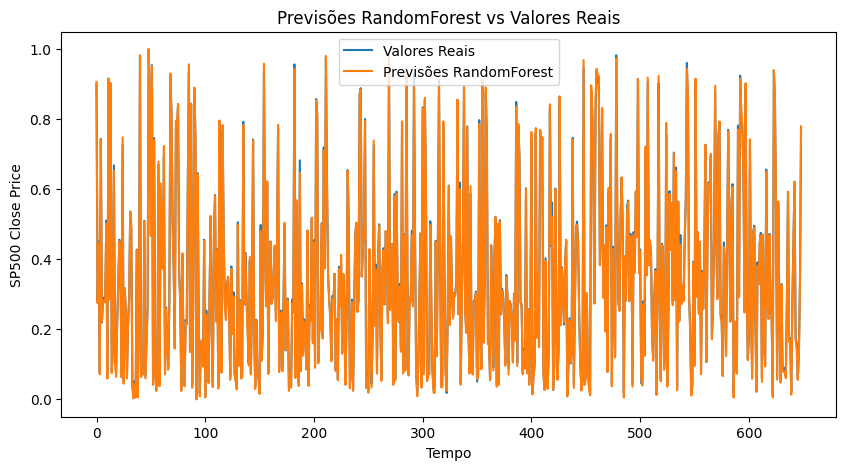

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test)), y_test_normalized, label='Valores Reais')
plt.plot(np.arange(len(y_pred_best)), y_pred_best_normalized, label='Previsões RandomForest')
plt.xlabel('Tempo')
plt.ylabel('SP500 Close Price')
plt.title('Previsões RandomForest vs Valores Reais')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [27]:
y_binary = (data['Close'].diff() > 0).astype(int).shift(-1).dropna()
X_binary = X.iloc[:-1, :]

In [28]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)


In [29]:
rf_best_bin = RandomForestRegressor(**best_params, random_state=42)
rf_best_bin.fit(X_train_bin, y_train_bin)
y_pred_bin = rf_best_bin.predict(X_test_bin)

In [30]:
y_pred_bin_class = (y_pred_bin > 0.5).astype(int)

In [31]:
accuracy = accuracy_score(y_test_bin, y_pred_bin_class)
f1 = f1_score(y_test_bin, y_pred_bin_class)

In [32]:
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Classification Report:\n {classification_report(y_test_bin, y_pred_bin_class)}")

Accuracy: 0.5100154083204931
F1-score: 0.5880829015544041
Classification Report:
               precision    recall  f1-score   support

         0.0       0.47      0.34      0.40       305
         1.0       0.53      0.66      0.59       344

    accuracy                           0.51       649
   macro avg       0.50      0.50      0.49       649
weighted avg       0.50      0.51      0.50       649



In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

In [36]:
rf = RandomForestRegressor(random_state=42)

In [37]:
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=3, n_jobs=-1, random_state=42, scoring='neg_mean_squared_error')


In [38]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='neg_mean_squared_error')

In [39]:
best_params_random = random_search.best_params_
best_mse_random = -random_search.best_score_

print(f"Best Parameters: {best_params_random}")
print(f"Best MSE: {best_mse_random}")

Best Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40}
Best MSE: 10.666676626477638


In [41]:
rf_best = RandomForestRegressor(**best_params_random, random_state=42)
rf_best.fit(X_train, y_train)
y_pred_best = rf_best.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred_best)

In [42]:
print(f"Final MSE on test data: {final_mse}")

Final MSE on test data: 8.03406818906321
